# Testing U-net testing Malaria Images

Testing U-net with images of P. vivax (malaria) infected human blood smears

https://www.kaggle.com/kmader/malaria-bounding-boxes

In [2]:
import numpy as np
import os
import sys
import random
import warnings

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K


from keras.optimizers import Adam

import tensorflow as tf

Using TensorFlow backend.


## Loading Images

### Parameters

In [3]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '../../data/raw_data/malaria/transformed_images/'
TEST_PATH = 'stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [4]:
train_ids = np.load(TRAIN_PATH+'malaria_images.npy' )
train_ids

array(['../../data/raw_data/malaria/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png',
       '../../data/raw_data/malaria/images/10be6380-cbbb-4886-8b9e-ff56b1710576.png',
       '../../data/raw_data/malaria/images/6b14c855-8561-417c-97a4-63fa552842fd.png',
       ...,
       '../../data/raw_data/malaria/images/e640ae51-cbf1-4a84-b7cf-d38b17f59c2f.png',
       '../../data/raw_data/malaria/images/38d1b930-dd97-4248-9160-e9389a1a8dd7.png',
       '../../data/raw_data/malaria/images/99e979d4-ee97-4d7f-9da6-00bead40db4d.png'],
      dtype=object)

In [5]:
test_ids = np.load(TRAIN_PATH+'malaria_test_images.npy' )

In [6]:
raw_train_masks=  np.load(TRAIN_PATH+'malaria_images_masks.npy' )
raw_test_masks=  np.load(TRAIN_PATH+'malaria_images_masks.npy' )

In [7]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print(X_train.shape)
print(Y_train.shape)

(1208, 128, 128, 3)
(1208, 128, 128, 1)


In [8]:

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    img = imread(id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    #mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    #for mask_file in next(os.walk(path + '/masks/'))[2]:
    #    mask_ = imread(path + '/masks/' + mask_file)
    #    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
    #                                  preserve_range=True), axis=-1)
    #    mask = np.maximum(mask, mask_)
    mask = np.expand_dims(resize(raw_train_masks[n], (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|██████████| 1208/1208 [06:05<00:00,  3.40it/s]


In [9]:
print("Get and resize test images")
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    img = imread( id_ )[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    
    mask = np.expand_dims(resize(raw_test_masks[n], (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    Y_test[n] = mask

print('Done!')

Get and resize test images
Getting and resizing test images ... 


100%|██████████| 120/120 [00:48<00:00,  2.42it/s]

Done!


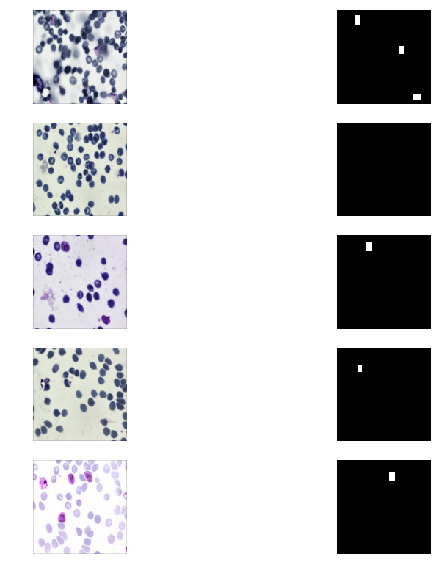

In [10]:
n_images = 5
fig, axes = plt.subplots(n_images,2,figsize=(10,10))
for i in range(n_images):
    #ix = random.randint(0, len(train_ids))
    ix = i
    axes[i,0].imshow(X_train[ix])
    axes[i,1].imshow(np.squeeze(Y_train[ix]), cmap='gray')

fig = plt.gcf()
for ax in fig.axes:
    ax.axis('off')

plt.show()

### IoU (Intersection of the union)
The intersection of the union(IOU): Measure the total number of shared pixels after applying the masks

\begin{equation*}
  IOU = \frac{I_1 \cup I_2}{I_1 \cap I_2}
\end{equation*}

In [11]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [12]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [13]:
def get_metrics_grafics(results):
    # 'val_loss', 'val_my_iou_metric', 'loss', 'my_iou_metric'
    plt.figure(figsize=(20,10))
    ## LOSS
    plt.subplot(221)
    plt.plot(results.history['loss'], label='Training loss')
    plt.plot(results.history['val_loss'], label='Validation loss')
    plt.legend(frameon=False)
    ## Intersection over union
    plt.subplot(222)
    plt.plot(results.history['my_iou_metric'], label='Training IoU')
    plt.plot(results.history['val_my_iou_metric'], label='Validation IoU')
    plt.legend(frameon=False)

    plt.show()

## U-Net

![title](../../u-net-architecture.png)

In [20]:
def unet(input_size = (128,128,3), droput_rate = 0.2):
    inputs = Input(input_size)
    s = Lambda(lambda x: x / 255) (inputs)

    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(s)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(rate=droput_rate)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(rate=droput_rate)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = [inputs], outputs = [conv10])

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [my_iou_metric])
    
    #model.summary()

    return model

### Test Model with 300 images

In [21]:
model = unet()

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 128, 128, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 128, 128, 64) 1792        lambda_3[0][0]                   
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_49[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [22]:

limit = 300
checkpointer = ModelCheckpoint('model-unet-malaria-kaggle-20190629_02.h5', verbose=1, save_best_only=True)
#results = model.fit(X_train[:limit], Y_train[:limit], validation_split=0.1, batch_size=5, epochs=50, 
#                    callbacks=[checkpointer])
results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=5, epochs=40, 
                    callbacks=[checkpointer])

Train on 966 samples, validate on 242 samples
Epoch 1/40
966/966 [==============================] - 20s 21ms/step - loss: 0.0506 - my_iou_metric: 0.0000e+00 - val_loss: 0.0372 - val_my_iou_metric: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.03722, saving model to model-unet-malaria-kaggle-20190629_02.h5
Epoch 2/40
966/966 [==============================] - 18s 19ms/step - loss: 0.0314 - my_iou_metric: 0.0000e+00 - val_loss: 0.0289 - val_my_iou_metric: 0.0000e+00

Epoch 00002: val_loss improved from 0.03722 to 0.02893, saving model to model-unet-malaria-kaggle-20190629_02.h5
Epoch 3/40
966/966 [==============================] - 18s 19ms/step - loss: 0.0226 - my_iou_metric: 0.0000e+00 - val_loss: 0.0203 - val_my_iou_metric: 0.0000e+00

Epoch 00003: val_loss improved from 0.02893 to 0.02034, saving model to model-unet-malaria-kaggle-20190629_02.h5
Epoch 4/40
966/966 [==============================] - 18s 19ms/step - loss: 0.0184 - my_iou_metric: 0.0000e+00 - val_loss: 0.0210 

966/966 [==============================] - 18s 18ms/step - loss: 0.0015 - my_iou_metric: 0.5572 - val_loss: 0.0294 - val_my_iou_metric: 0.2494

Epoch 00038: val_loss did not improve from 0.01520
Epoch 39/40
966/966 [==============================] - 18s 18ms/step - loss: 0.0011 - my_iou_metric: 0.5854 - val_loss: 0.0393 - val_my_iou_metric: 0.2594

Epoch 00039: val_loss did not improve from 0.01520
Epoch 40/40
966/966 [==============================] - 18s 18ms/step - loss: 0.0011 - my_iou_metric: 0.5894 - val_loss: 0.0359 - val_my_iou_metric: 0.2615

Epoch 00040: val_loss did not improve from 0.01520


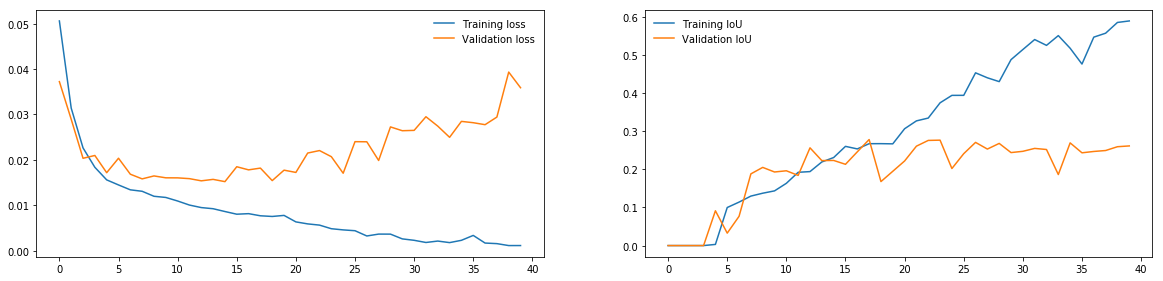

In [23]:
get_metrics_grafics(results)

In [24]:
results_test = model.evaluate(x = X_test[:limit], y = Y_test[:limit])

120/120 [==============================] - 2s 16ms/step


In [25]:
results_test

[0.11353005667527517, 0.0]

## Predictions

In [26]:
# Predict on train, val and test
model = load_model('model-unet-malaria-kaggle-20190629_00.h5', custom_objects={'my_iou_metric': my_iou_metric})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

120/120 [==============================] - 0s 3ms/step


### IMAGE |  MASK | PREDICTION

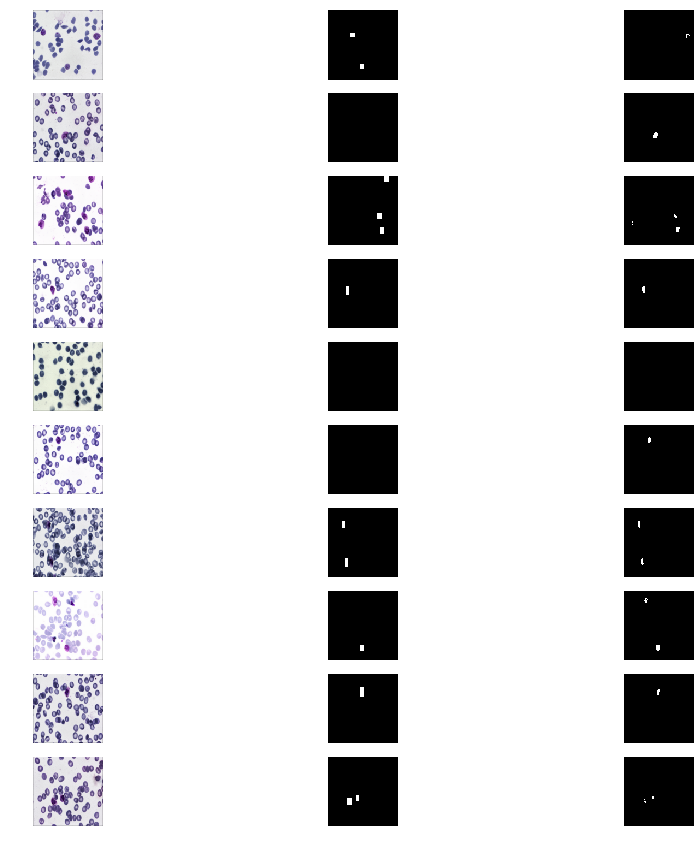

In [24]:
n_images = 10

fig, axes = plt.subplots(n_images,3,figsize=(15,15))

for i in range(n_images):
    ix = random.randint(0, len(preds_train_t-1))
    axes[i,0].imshow(X_train[ix])
    axes[i,1].imshow(np.squeeze(Y_train[ix]), cmap='gray')
    axes[i,2].imshow(np.squeeze(preds_train_t[ix]), cmap='gray')

fig = plt.gcf()
for ax in fig.axes:
    ax.axis('off')

plt.show()

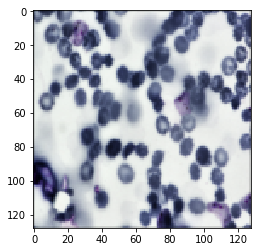

In [81]:
plt.imshow(X_train[0] )

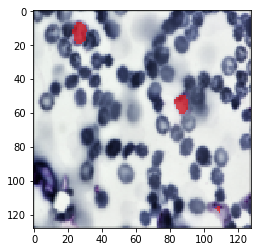

In [82]:
plt.imshow(X_train[0] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(preds_train_t[0]>0, 1, np.nan)), cmap='Set1',alpha=0.7)


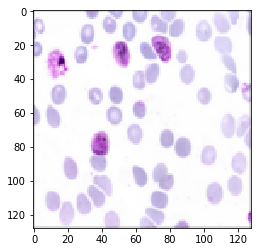

In [83]:
plt.imshow(X_train[4] ) 

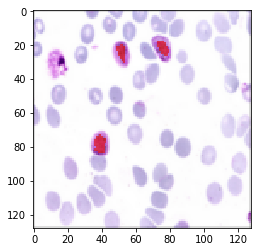

In [84]:
plt.imshow(X_train[4] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(preds_train_t[4]>0,1, np.nan)), cmap='Set1',alpha=0.7)

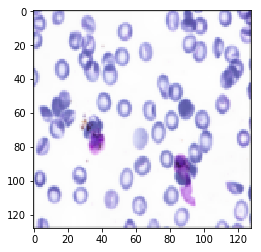

In [85]:
plt.imshow(X_train[7] ) 

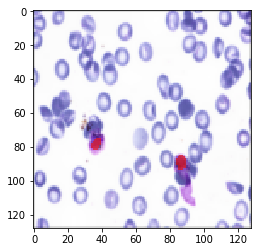

In [86]:
plt.imshow(X_train[7] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(preds_train_t[7]>0, 1, np.nan)), cmap='Set1',alpha=0.7)

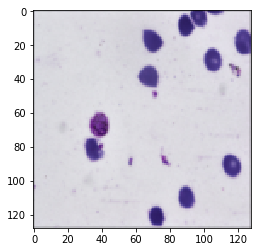

In [89]:
plt.imshow(X_train[9] )

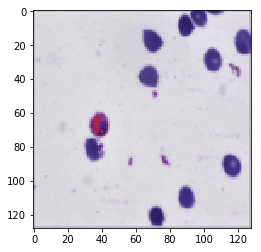

In [88]:
plt.imshow(X_train[9] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(preds_train_t[9]>0, 1, np.nan)), cmap='Set1',alpha=0.7)

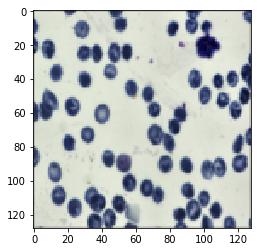

In [91]:
plt.imshow(X_train[50] ) 

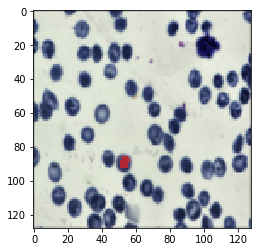

In [93]:
plt.imshow(X_train[50] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(preds_train_t[50]>0, 1, np.nan)), cmap='Set1',alpha=0.7)